# Setup
For the experimenter - no need to worry about this.

In [78]:
%%capture
%load_ext autoreload
%autoreload 2

from glob import glob
import random
from scipy import stats

from pilot import *
%matplotlib inline
plt.style.use("ggplot")

LOGDIR = os.path.join(os.getcwd(), 'logs')

In [79]:
NBLOCKS = 5
NTRIALS = 10

dims = [10, 100, 200]
scales = [0.25, 0.50, 0.75]
experiments = []
for d in dims:
    for s in scales:
        experiments.append({'ndims': d, 'scale': s})
        
# Randomly shuffle the experiments
my_experiments = random.sample(experiments, len(experiments))

In [80]:
practice_experiment = {'ndims': 200, 'scale': 0.25}

In [86]:
def run_experiment(x, participant, nblocks=NBLOCKS, ntrials=NTRIALS, logdir=LOGDIR, seed=None):
    np.random.seed(seed)
    config = get_config(nblocks=nblocks, ntrials=ntrials, ndims=x['ndims'], std=x['scale'], print_feedback=True)
    blocks = get_blocks(config)
    pilot_experiment(blocks, config, participant, logdir)

In [87]:
def show_samples(seed=None):
    np.random.seed(seed)
    config = get_config(nblocks=1, ntrials=5, std=0.25, ndims=200, print_feedback=False)
    examples1 = [get_mean_example(config, 'bivimias') for _ in range(config.ntrials)][:5]
    examples2 = [get_mean_example(config, 'lorifens') for _ in range(config.ntrials)][:5]
    plt.figure()
    imshows([x['img'] for x in examples1], labels=['']*2 + ['Unknown Artist 1'] + ['']*2)
    plt.figure()
    imshows([x['img'] for x in examples2], labels=['']*2 + ['Unknown Artist 2'] + ['']*2)

# Participant info
Please enter the following details.

In [83]:
participant = {
    'id_num': 5,
    'initials': 'GG',
}

# The Art Show Game

You are a collector of abstract paintings. At an art show, you are asked to help distinguish between the works of two up-and-coming abstract painters: Salvatore Bivimiano and Micah Lorifensky. Though you've never seen their art before, you have a keen eye and are able to put it to use.

As part of a recent trend in the world of abstract art, Bivimiano and Lorifensky have produced collections of multiple paintings that are all variants of the same theme. For instance:

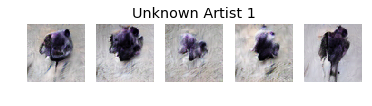

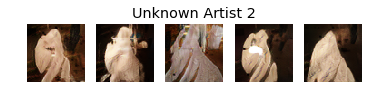

In [88]:
show_samples(seed=0)

## Your task

In the following exhibits, you'll be presented with different paintings, and will be asked to determine the artist. Initially, you will not know; however, after each determination, you'll receive feedback telling you whether you were correct. Note that in each exhibit, you'll see work from the two painters in equal proportion. There are nine exhibits in total.

## Practice exhibit

Question: 1/10
Block: 1/5
Correct: 0.0000

Is this a Bivimiano or a Lorifensky?


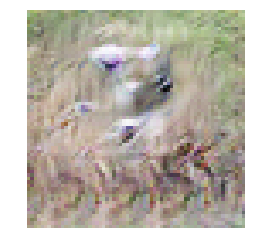

SEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnQml2aW1pYW5vJywgc3R5bGU9QnV0dG9uU3R5bGUoKSksIEJ1dHRvbihkZXNjcmlwdGlvbj11J0xvcmlmZW5za3knLCBzdHlsZT3igKY=


In [89]:
run_experiment(practice_experiment, participant, nblocks=5, ntrials=2, logdir=os.path.join(LOGDIR, 'practice'), seed=0)

## Exhibit 0

Question: 10/50
Block: 1/5
Correct: 1.0000

Is this a Bivimiano or a Lorifensky?


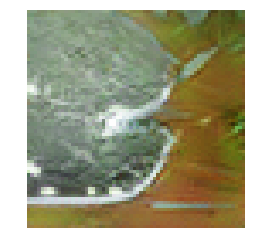

SEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnQml2aW1pYW5vJywgc3R5bGU9QnV0dG9uU3R5bGUoKSksIEJ1dHRvbihkZXNjcmlwdGlvbj11J0xvcmlmZW5za3knLCBzdHlsZT3igKY=


In [90]:
run_experiment(my_experiments[0], participant, logdir=LOGDIR)

## Exhibit 1

In [ ]:
run_experiment(my_experiments[1], participant, logdir=LOGDIR)

## Exhibit 2

In [ ]:
run_experiment(my_experiments[2], participant, logdir=LOGDIR)

## Exhibit 3

In [ ]:
run_experiment(my_experiments[3], participant, logdir=LOGDIR)

## Exhibit 4

In [ ]:
run_experiment(my_experiments[4], participant, logdir=LOGDIR)

## Exhibit 5

In [ ]:
run_experiment(my_experiments[5], participant, logdir=LOGDIR)

## Exhibit 6

In [ ]:
run_experiment(my_experiments[6], participant, logdir=LOGDIR)

## Exhibit 7

In [ ]:
run_experiment(my_experiments[7], participant, logdir=LOGDIR)

## Exhibit 8

In [ ]:
run_experiment(my_experiments[8], participant, logdir=LOGDIR)

# Analysis

In [ ]:
assert(False)

In [7]:
def get_all_trials(logdir, dims='*', scale='*', participants='*'):
    assert(participants == '*' or type(participants) == list)
    trials = []
    for p in participants:
        query_path = os.path.join(logdir, "participant_{}".format(p), "*ndims-{}-*std-{}-*".format(dims, scale))
        trials += glob(query_path)
    return trials

In [76]:
get_all_trials(LOGDIR)

['/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-10-std-0.4- Fri Dec  7 00:18:33 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-10-std-0.6- Fri Dec  7 00:29:03 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-100-std-0.4- Fri Dec  7 00:25:01 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-100-std-0.4- Fri Dec  7 00:26:24 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-100-std-0.6- Fri Dec  7 00:16:24 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-100-std-0.6- Fri Dec  7 00:22:59 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-200-std-0.2- Fri Dec  7 00:27:48 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-200-std-0.4- Fri Dec  7 00:20:10 2018',
 '/Users/ggrand/Desktop/dimensionality/notebooks/logs/participant_0/ndims-200-std-0.6- Fri

In [9]:
def get_acc_per_block(outdir):
    # config = dict(np.load(os.path.join(outdir, "config.npz")).items())
    blocks = [
        list(x) for _, x in
        sorted(np.load(
            os.path.join(outdir, "blocks.npz")
        ).items())
    ]
    assert experiment_is_complete(blocks)
    acc_per_block = []
    for block in blocks:
        acc = np.mean([
            x["category"] == x["predicted_category"]
            for x in block
        ])
        acc_per_block.append(acc)
    return acc_per_block

In [68]:
# results: list of result objects
#     result: np.array (n_participants * n_blocks)
# ndims: list of ints corresponding to ndim of each result
# scale: float corresponding to std used across all results

def plot_learning(results, ndims, scale):
    plt.figure(figsize=(10., 10.))
    
    for i, r in enumerate(results):
        mean_r = np.mean(r, axis=0)
        std_r = np.std(r, axis=0)
        sem_r = stats.sem(r, axis=0, ddof=0)
        n_r = r.shape[0]
        plt.errorbar(
            range(len(mean_r)),
            mean_r,
            sem_r,
            capsize=5,
            label="ndims={} (N={})".format(ndims[i], n_r)
        )
        
    plt.plot([0, 4], [0.5, 0.5], color='gray', linestyle="--")
    
    plt.xticks(range(0, 5))
    plt.xlabel("Block")

    plt.ylim(0., 1.2)
    plt.ylabel("Proportion correct")

    plt.title(r'Human performance ($\sigma={}$)'.format(scale))

    plt.legend()
    plt.show()

In [77]:
# P_QUERY = '*'
SCALE_QUERY = 0.25

acc_per_block_200 = np.array([get_acc_per_block(x) for x in get_all_trials(LOGDIR, dims=200, scale=SCALE_QUERY, participants=P_QUERY)])
acc_per_block_100 = np.array([get_acc_per_block(x) for x in get_all_trials(LOGDIR, dims=100, scale=SCALE_QUERY, participants=P_QUERY)])
acc_per_block_10 = np.array([get_acc_per_block(x) for x in get_all_trials(LOGDIR, dims=10, scale=SCALE_QUERY, participants=P_QUERY)])

print(acc_per_block_200)
print(acc_per_block_100)
print(acc_per_block_10)

[[0.8 1.  0.9 0.9 1. ]
 [1.  1.  0.9 0.9 0.9]
 [0.6 0.9 0.9 1.  1. ]]
[[0.9 1.  0.9 1.  1. ]
 [0.9 1.  1.  1.  1. ]
 [1.  0.9 1.  1.  1. ]]
[[1.  1.  1.  1.  1. ]
 [1.  1.  1.  0.9 1. ]
 [1.  1.  1.  0.9 1. ]]


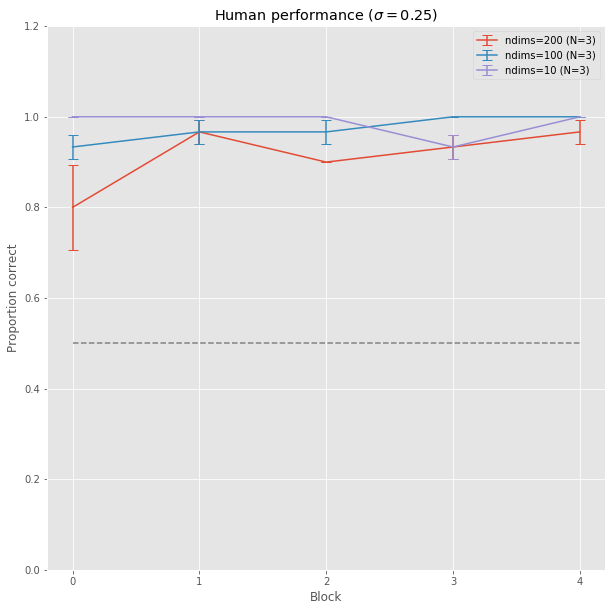

In [75]:
plot_learning([acc_per_block_200, acc_per_block_100, acc_per_block_10], [200, 100, 10], SCALE_QUERY)

In [57]:
# Compare human and NB results

def compare_results(results, ndims, std, labels):
    plt.figure(figsize=(10., 10.))
    
    for i, r in enumerate(results):
        mean_r = np.mean(r, axis=0)
        std_r = np.std(r, axis=0)
        sem_r = stats.sem(r, axis=0, ddof=0)
        n_r = r.shape[0]
        plt.errorbar(
            range(len(mean_r)),
            mean_r,
            sem_r,
            capsize=5,
            label=labels[i]
        )
        
    plt.plot([0, 4], [0.5, 0.5], color='gray', linestyle="--")
    
    plt.xticks(range(0, 5))
    plt.xlabel("Block")

    plt.ylim(0., 1.2)
    plt.ylabel("Proportion correct")

    plt.title(r'$d = {}, \sigma = {}$'.format(ndims, std))

    plt.legend()
    plt.show()

In [58]:
QUERY = {
    'ndims': 200,
    'std': 0.25,
    'participants': [2, 3, 4]
}

human_results = np.array([get_acc_per_block(x) for x in get_all_trials(LOGDIR, dims=QUERY['ndims'], scale=QUERY['std'], participants=QUERY['participants'])])
print(human_results)

[[0.8 1.  0.9 0.9 1. ]
 [1.  1.  0.9 0.9 0.9]
 [0.6 0.9 0.9 1.  1. ]]


In [59]:
ex_idx = experiments.index({'ndims': QUERY['ndims'], 'scale': QUERY['std']})
print(ex_idx)

6


In [60]:
z_model_results = list(np.load('logs/naive_bayes/z_results.npz')['arr_0'])
print(len(z_model_results[ex_idx]))

100


In [61]:
img_model_results = list(np.load('logs/naive_bayes/img_results.npz')['arr_0'])
print(len(img_model_results[ex_idx]))

IOError: [Errno 2] No such file or directory: 'logs/naive_bayes/img_results.npz'

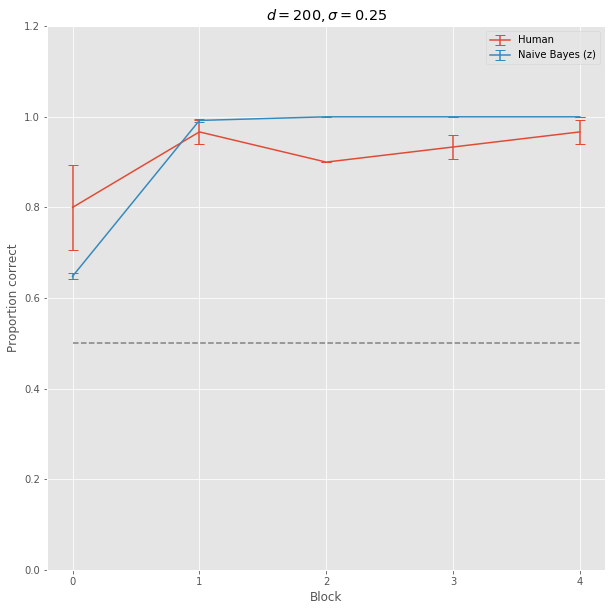

In [62]:
compare_results([human_results, z_model_results[ex_idx]], QUERY['ndims'], QUERY['std'], labels = ['Human', 'Naive Bayes (z)', 'Naive Bayes (img)'])

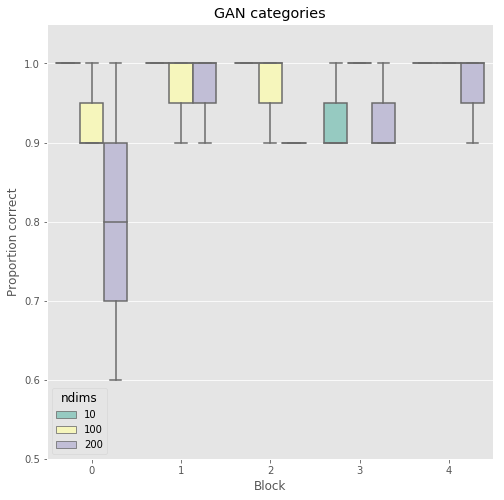

In [34]:
import seaborn as sns
import pandas as pd

# good coding alex!
df = pd.DataFrame(sum([sum([[{
    "block": i,
    "accuracy": acc,
    "ndims": ndims
} for i, acc in enumerate(accs)]
    for accs in acc_per_block], [])
 for ndims, acc_per_block in {
     200: acc_per_block_200,
     100: acc_per_block_100,
     10: acc_per_block_10
 }.items()], []))

plt.figure(figsize=(8., 8.))
ax = sns.boxplot(
    x="block",
    y="accuracy",
    hue="ndims",
    data=df,
    palette="Set3"
)
    
plt.xticks(range(0, 5))
plt.xlabel("Block")

plt.ylim(0.5, 1.05)
plt.ylabel("Proportion correct")

plt.title("GAN categories")
plt.show()

# Viz

In [ ]:
SEED = 4
    
a, b, _ = rand_categories()

def reveal_examples(std=0.25):
    print('std = {}'.format(std))
    for d in [10, 100, 200]:
        config = get_config(nblocks=1, ntrials=10, std=std, ndims=d, print_feedback=False, seed=SEED)
        config.bivimias = a
        config.lorifens = b
        examples1 = [get_mean_example(config, 'bivimias') for _ in range(config.ntrials)][:5]
        plt.figure()
        imshows([x['img'] for x in examples1], labels=['{}d'.format(d)] * 5)

In [ ]:
reveal_examples(std=0.25)

In [ ]:
reveal_examples(std=0.50)

In [ ]:
reveal_examples(std=0.75)

In [ ]:
print('Scale')
for s in [0.25, 0.50, 0.75]:
    config = get_config(nblocks=1, ntrials=5, std=s, ndims=200, print_feedback=False, seed=SEED)
    config.bivimias = a
    config.lorifens = b
    examples1 = [get_mean_example(config, 'bivimias', seed=SEED) for _ in range(config.ntrials)][:5]
    plt.figure()
    imshows([x['img'] for x in examples1], labels=['{}s'.format(s)] * 5)

In [ ]:
config = get_config(nblocks=1, ntrials=5, std=0.25, ndims=200, print_feedback=False)
examples1 = [get_mean_example(config, 'bivimias') for _ in range(config.ntrials)][:5]
imshows([x['img'] for x in examples1], labels=[x['category'] for x in examples1])

In [ ]:
examples1 = [get_mean_example(config, 'lorifens') for _ in range(config.ntrials)][:5]
imshows([x['img'] for x in examples1], labels=[x['category'] for x in examples1])